# Introduction and Objective
The objective of this project is to use deep learning techniques to classify text from news articles into four different categories. This project can be found on Github at: https://github.com/highdeltav/DeepLearningWeek6

## Libraries and Helper Functions

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing  import lower_to_unicode
from gensim.models import Word2Vec
from gensim.downloader import load as gensim_downloader 
from gensim.models import Phrases
from gensim.test.utils import datapath
from gensim import utils

from nltk.corpus import stopwords

from matplotlib import pyplot as plt
from seaborn import histplot
from wordcloud import WordCloud, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import json


In [12]:
def json_out(d, filename):
    """ Export a dictionary to a JSON """
    with open(f"{filename}.json", "w") as save_file:
        json.dump(d, save_file)
        
def json_to_dict(filename):
    """ Convert a JSON to a dictionary """
    with open(f"{filename}", 'r') as file:
        d = json.load(file)
    return d

def rm_stop_words(text, other_words = None):
    """Remove stop words from text"""    
    # Add our own words
    stop_words = stopwords.words('english')
    if other_words != None:
        stop_words.extend(other_words)
    
    words = [word for word in text.split() if word.lower() not in stop_words]
    new_text = " ".join(words)
    return new_text

def plot_all_plots(d, plot_type = 'accuracy', cols = 3):
    """Plot stats of all histories in a dictionary on a single chart"""
    
    total_plots = len(d)
    rows = int(np.ceil(total_plots/cols))
    plt.figure(figsize = (5*cols,5*rows))
    

    # Postion differently depending on amount of rows
    title_y = .98
    if rows >= 3:
        title_y = .9
    elif rows == 2:
        title_y = .93
    #Set the amount of columns
    
   
    for i, model in enumerate(d):
        
         #Check to see which variables to plot
        if plot_type == 'accuracy':
            y_axis_train = d[model]['accuracy']
            y_axis_val = d[model]['val_accuracy']
            title = 'Accuracy'
            y_limit = [.5,1]
        elif plot_type == 'loss':
            y_axis_train = d[model]['loss']
            y_axis_val = d[model]['val_loss']
            title = 'Loss'
            y_limit = [0,1.5]
        else:
            print('Avaliable options are: Loss and Accuracy')
            return
        
        
        x_epochs = np.arange(1,len(y_axis_train)+1)
        plt.subplot(rows, cols, i+1)
        plt.plot(x_epochs, y_axis_train, label = 'Training')
        plt.plot(x_epochs, y_axis_val,   label = 'Validation')
        plt.ylim(y_limit)
        plt.title(f"{model}")
        plt.xlabel('Epochs')
        plt.ylabel(title)

        plt.legend()

    plt.suptitle(title, fontsize=20, y = title_y)
    plt.show()
    
def plot_models_together(d):
    """Plots all of the metircs curves on 4 plots in 1 figure"""
   
    fig, axes = plt.subplots(2,2)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    #ax.plot(range(self.epochs), val_acc,   label = 'Validation')
    plot_types = ['accuracy','val_accuracy','loss','val_loss']
    for p in plot_types:
        if p == 'val_accuracy':
            ylab = 'Accuracy'
            title = 'Validation Accuracy'
            lim = [.5,1]
            ax = axes[0,0]
        elif p == 'accuracy':
            ylab = 'Accuracy'
            title = 'Training Accuracy'
            lim = [.5,1]
            ax = axes[0,1]
        elif p =='val_loss':
            ylab = 'Loss'
            title = 'Validation Loss'
            lim = [0,1.5]
            ax = axes[1,0]
        elif p == 'loss':
            ylab = 'Loss'
            title = 'Training Loss'
            lim = [0,1.5]
            ax = axes[1,1]
        #Add data from all of the models
        for model in d:
            train_acc = (d[model][p])
            x_epochs = np.arange(1,len(d[model][p])+1)
            ax.plot(x_epochs, train_acc, label = model)
        
        ax.set_ylim(lim)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylab)
        ax.set_title(title)
        ax.legend()
    plt.suptitle('Model Comparison', fontsize=20, y = .93)
    plt.show()
def predict_from_model(model, X):
    """Outputs predictions from the model output"""
    preds = model.predict(X)
    #Returns the hightsest value from the SoftMax output
    return np.argmax(preds, axis = 1)


def create_summary_table(d):
    """Creates a summary table from a dictionary"""

    max_acc = []
    min_loss = []
    max_val_acc = []
    epoch_min_val_loss = []
    min_val_loss = []
    row_names = []
    runtime = []
    for each in d:
        max_acc.append(max(d[each]['accuracy']))
        min_loss.append( min(d[each]['loss']))
        max_val_acc.append(max(d[each]['val_accuracy']))
        min_val_loss.append(min(d[each]['val_loss']))
        epoch_min_val_loss.append(np.argmin(d[each]['val_loss']))
        row_names.append(each)
    df = pd.DataFrame(list(zip(row_names, max_acc,min_loss, max_val_acc, min_val_loss, epoch_min_val_loss)),
                     columns = ['Model','Max Acc', 'Minnimum Loss','Max Val Acc','Min Val Loss','Epoch of Min Val Loss']).round(3)
    display(df)


# Data
## Information and Initial EDA
This dataset is a subset of the [AG news classification dataset](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which contains 1 million news articles. This subset was compiled by Xiang Zhang for his paper [“Character-level Convolutional Networks for Text Classification.”](https://arxiv.org/abs/1509.01626v3) and uploaded to [Kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset.)

This dataset is composed of two different files, one us designated as training data, and one is designated as test data. There are 120,000 records in the training data, and 7,600 in the test data. Each record is a listing of a short news article for classification. It has three features, one is the 'Class Index', one is the 'Title' of the article, and one is the 'Description.' There are 30,000 articles of each class in the training dataset, and 1,900 in the test set. All of the articles are evenly distributed, so there is no class imbalance. 

The longest article is 985 characters, and the shortest has only 6 words. There are also no null values in the data that needed to be addressed.


In [4]:
# The class ids are numbered 1-4 where 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech.
train = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
test = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')
class_ids = ['World','Sports','Business','Sci/Tech']

In [4]:
train.tail()

,Class Index,Title,Description
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...
119999,2,Nets get Carter from Raptors,INDIANAPOLIS -- All-Star Vince Carter was trad...


In [5]:
print(f"Train: {train.describe()}")
print(f"Test: {test.describe()}")

Train:          Class Index
count  120000.000000
mean        2.500000
std         1.118039
min         1.000000
25%         1.750000
50%         2.500000
75%         3.250000
max         4.000000
Test:        Class Index
count  7600.000000
mean      2.500000
std       1.118108
min       1.000000
25%       1.750000
50%       2.500000
75%       3.250000
max       4.000000


In [6]:
## Verify there are no null values in the description and predictions
print(train[train['Description'].isnull()])
print(train[train['Class Index'].isnull()])

Empty DataFrame
Columns: [Class Index, Title, Description]
Index: []
Empty DataFrame
Columns: [Class Index, Title, Description]
Index: []


In [7]:
print(f"Longest article: {train['Description'].map(lambda x: len(x)).max()} words")
print(f"Shortest article: {train['Description'].map(lambda x: len(x)).min()} words")

Longest article: 985 words
Shortest article: 6 words


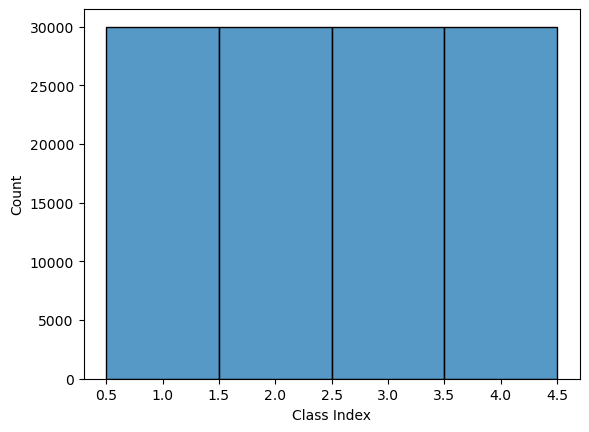

In [6]:
histplot(train['Class Index'], discrete = True)
plt.show()

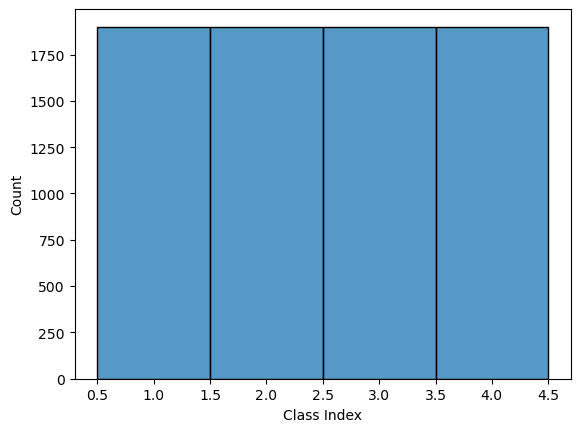

In [70]:
histplot(test['Class Index'], discrete = True)
plt.show()

In [71]:
pd.set_option('display.max_colwidth', None)
#train[train['Description'].str.contains('[UNK]')]

## Pre-processing
For this project, I decided to just do the text analysis on the description, and ignore the the title. I considered just using the title, or concatenating the title and the description, but in the end, decided to keep it simple, and just use the description field. Evaluating which of those options would yield the best results, could be an interesting expansion of this project, but is out of scope for this specific project.

The first thing I did was remove all of the stop words from the list gensim library. This removes words that are normally common to all the data. Words such as 'the.' This is not always the recommended approach, but in this instance, I decided it would be beneficial.

In addition to removing the stop words, I also stripped the articles of punctuation and made all of the words lowercase.

I also changed the category designations from 1 to 4, to 0 to 3, to make it easier to to use them as classifiers in the machine learning process. 

In [7]:
# Make the class designations 0 to 3 instead of 1 to 4
train['Class Index'] = train['Class Index']-1
test['Class Index'] = test['Class Index']-1

In [13]:
# Process train data
train['Description'] = train['Description'].apply(lower_to_unicode)
train['Description'] = train['Description'].apply(strip_punctuation)
train['Description'] = train['Description'].apply(rm_stop_words)
#train['Description'] = train['Description'].apply(rm_stop_words, args = ([remove_word_list]))

# Prccess test data
test['Description'] = test['Description'].apply(lower_to_unicode)
test['Description'] = test['Description'].apply(strip_punctuation)
test['Description'] = test['Description'].apply(rm_stop_words)
#test['Description'] = test['Description'].apply(rm_stop_words, args = ([remove_word_list]))


In [14]:
train['Description']

0         reuters short sellers wall street dwindling ba...
1         reuters private investment firm carlyle group ...
2         reuters soaring crude prices plus worries econ...
3         reuters authorities halted oil export flows ma...
4         afp tearaway world oil prices toppling records...
                                ...                        
119995    karachi reuters pakistani president pervez mus...
119996    red sox general manager theo epstein acknowled...
119997    miami dolphins put courtship lsu coach nick sa...
119998    pittsburgh ny giants time 1 30 p line steelers...
119999    indianapolis star vince carter traded toronto ...
Name: Description, Length: 120000, dtype: object

## EDA Part Two
After I had done some initial preprocessing of the data, I did some additional EDA.  I used CountVectorizer to tokenize the data, so I could have a better understanding of it. I also created a word cloud, and a most common words list so I could see if there were other words that I wanted to remove.



In [15]:
# Creeate a CountVectorizer to do more data analysis
vectorizer = CountVectorizer()
vec = vectorizer.fit_transform(train['Description'])


In [16]:
# Create a list of words sorted by their frequency
word_sum_list = vec.sum(axis = 0).tolist()[0]
feature_list = vectorizer.get_feature_names_out()

most_words_list=sorted(zip(feature_list,word_sum_list), key = lambda x: x[1],reverse = True)

In [17]:
print(f"Total number of words: {len(word_sum_list)}")

Total number of words: 60564


In [18]:
most_word_dictionary = dict(most_words_list[:100])

In [20]:
word_freq = {}
for i, words in enumerate(most_words_list[:10]):
    print(f"{i+1}. {words[0]}: {words[1]}")

1. 39: 31874
2. said: 20098
3. new: 17392
4. reuters: 15078
5. two: 9248
6. us: 9079
7. quot: 8941
8. year: 8923
9. first: 8596
10. ap: 8499


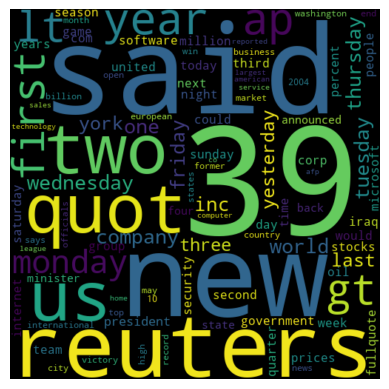

In [21]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 500, height = 500).generate_from_frequencies(most_word_dictionary)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Additional Word Removal
After looking at the tops words list and the word cloud, I decided to remove the names of the news organizations such as "Reuters." I did this because I didn't want the data to rely to much on the news organizations for classification, when additional data might be from an unseen one. In addition, I also removed some words that appeared to be artifacts in the data gathering process such as “fullquote.”

### Text Summary
There were a total of 60554 words, after the removal of the stop words. “Said” was the word that was used the most used word, used 20,098 times.

In [23]:
# Add words to remove that were not n the default stop words list
remove_word_list = ["quot", "fullquote", "reuters", 'ap', '39', 'afp', 'lt', 'gt', 'quote', 'sn' ]

# Remove additional words
train['Description'] = train['Description'].apply(rm_stop_words, args = ([remove_word_list]))
test['Description'] = test['Description'].apply(rm_stop_words, args = ([remove_word_list]))


In [24]:
# Create a CountVectorizer to do more data analysis
vectorizer = CountVectorizer()
vec = vectorizer.fit_transform(train['Description'])

# Create a list of words sorted by their frequency
word_sum_list = vec.sum(axis = 0).tolist()[0]
feature_list = vectorizer.get_feature_names_out()

most_words_list=sorted(zip(feature_list,word_sum_list), key = lambda x: x[1],reverse = True)
most_word_dictionary = dict(most_words_list[:100])

# Create Total Words for Models
total_words = len(word_sum_list)

word_freq = {}
for i, words in enumerate(most_words_list[:10]):
    print(f"{i+1}. {words[0]}: {words[1]}")

1. said: 20098
2. new: 17392
3. two: 9248
4. us: 9079
5. year: 8923
6. first: 8596
7. monday: 7506
8. wednesday: 7461
9. tuesday: 7388
10. one: 7365


In [33]:
print(f"Total Words: {total_words}")

Total Words: 60554


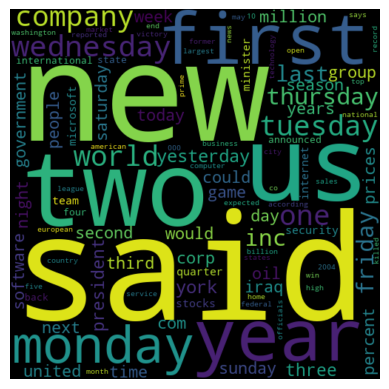

In [25]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 500, height = 500).generate_from_frequencies(most_word_dictionary)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Split train/test
I split the train set into a train and validation set, and kept the test set for model testing at the end. 

In [28]:
X_train, X_val, y_train, y_val = train_test_split(train['Description'], train['Class Index'], random_state = 42)
X_test = test['Description']
y_test = test['Class Index']

## Create Text Vectorization Layer
In order to pass the vectorized text to Keras, I created a layer that took the X_train data, and vectorized it. This is the layer that our text data will be passed to for training and testing purposes. I did make a concious choice to not pass the validation data to this layer as well. While it would help the validation data have better accuracy, and add additional words to the vocabulary, it would be sacrificing the ability in our testing to see what completely new data looks like, where not all of its words have been fit with the text vectorization layer. 

In [31]:
# Create the enocder for the text vectorizaton layer
#number_of_words = 1000

vectorize_layer = tf.keras.layers.TextVectorization()
vectorize_layer.adapt(list(X_train))
word_count = vectorize_layer.vocabulary_size()

In [30]:
print(f"Word Count: {word_count}")

Word Count: 54560


## Word2Vec
I decided to got a step beyond just tokenizing the data and create a Word2Vec model. This is a model that tries to estimate the context of words, instead of just going by the quantity of each word. It often uses a metric like cosine distance too see if a word is similar. Word vectors are passed to a model and this trained with a simple neural net. This information is then passed to an embedding layer as weights, for model training.

For training this WordVec model, I used the Gensim library to generate a model based on the training data. After it generated the model, I then had to transfer this to a matrix, that could be used as the weights for the embedding layer. Saturn Clouds [blog post](https://saturncloud.io/blog/using-pretrained-gensim-word2vec-embeddings-in-keras-a-comprehensive-guide/) was invaluable in learning how to do this. 

In [49]:
# Create a dictionary of the vectors for training the WordVec Model
word_idx = {}
for i, word in enumerate(vectorize_layer.get_vocabulary()):
    word_idx[word] = i

In [54]:
#https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

from gensim.test.utils import datapath
from gensim import utils

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self,texts):
        self.texts = texts
    def __iter__(self):
        
        for line in self.texts:
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

    

In [56]:
w2v_model = Word2Vec(sentences=MyCorpus(X_train), vector_size = 256)
print('Finished')

Finished


In [57]:
# See what my model thinks is similar to the word 'score.'
w2v_model.wv.most_similar('score')

[('scoring', 0.9402279257774353),
 ('ball', 0.9141973853111267),
 ('yard', 0.895178496837616),
 ('seconds', 0.8881029486656189),
 ('touchdown', 0.8861629366874695),
 ('goal', 0.8822108507156372),
 ('stubblefield', 0.8820501565933228),
 ('tied', 0.872307300567627),
 ('offense', 0.8630639314651489),
 ('passes', 0.8618302345275879)]

In [58]:
for index, word in enumerate(w2v_model.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(w2v_model.wv.index_to_key)} is {word}")

word #0/20690 is said
word #1/20690 is new
word #2/20690 is two
word #3/20690 is us
word #4/20690 is year
word #5/20690 is first
word #6/20690 is wednesday
word #7/20690 is monday
word #8/20690 is tuesday
word #9/20690 is one


In [59]:
#Modified from code at https://saturncloud.io/blog/using-pretrained-gensim-word2vec-embeddings-in-keras-a-comprehensive-guide/

# Create the embeding matrix fromt he WordVec Model
max_words = word_count
embed_size = 256
nb_words = min(max_words, len(word_idx))
embedding_matrix = np.zeros((nb_words, embed_size))

# Loop through the words and assign their values to the weight matrix
for word, i in word_idx.items():
    if i >= max_words:
        continue
    if word in w2v_model.wv.key_to_index:
        embedding_matrix[i] = w2v_model.wv.get_vector(word)

# Model Building
## Class Creation
I created a custom class that inherits the Keras model, and added a custom callback that would save the data after every epoch, instead of just at the end of the model run.


In [50]:
class CustomCallback(keras.callbacks.Callback):
    """Saves data to a dictionary in the class"""
    def __init__(self, model):
        super().__init__()
        self.model = model
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        stats = self.model.stats[self.model.name]
        stats['epochs'] += 1
        for key in keys:
            if key not in stats:
                stats[key] = []
            stats[key].append(logs[key])
        
        #print(f"Total Epochs Run: {stats['epochs']}")
        

In [51]:
# Model Class
class Model_Seq(Sequential):
    """ Inherits the Sequential class"""
    def __init__(self, model_layers, name = 'model',
                 X_train = X_train,
                 y_train = y_train,
                 X_val = X_val,
                 y_val = y_val,
                 inital_lr = .001,
                 chart_title = None):
        super().__init__()
        
        tf.random.set_seed(846)
        self.call_backs = CustomCallback(self)
        self.add_layers(model_layers)
        self._name = name
        self.stats = {self.name:{'epochs': 0}}
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        self.metrics1 = ['accuracy']
        self.lr = inital_lr
        if chart_title == None:
            self.chart_title = self.name
        else:
            self.chart_title = chart_title
        self.compile_model(self.lr)
        
    def add_layers(self,layers1):
        """Adds layers to the model"""
        for layer in layers1:
            self.add(layer)
            
    def compile_model(self, learning_rate = None):
        """ Compiles the model, with an optional learning rate"""
        if learning_rate == None:
            learning_rate = self.lr
        self.compile(loss=self.loss_fn,
              optimizer=tf.keras.optimizers.Adam(learning_rate =learning_rate),
              metrics=self.metrics1)
    
    def train_model(self, epochs, batch_size = 64):
        """Trains the model"""
        self.fit(
            x=self.X_train,
            y=self.y_train,
            validation_data = (self.X_val, self.y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=self.call_backs,
            shuffle=True,
            class_weight=None,
            sample_weight=None,
            initial_epoch=self.stats[self.name]['epochs']
)
    
    def rename(self,new_name):
        """Renames the Model"""
        self.stats[new_name] = self.stats.pop(self.name)
        self._name = new_name


## Architecture
It was at this point that I began building the models that I wanted to test. I decided to start off with two different neural network architectures. I chose to do a LSTM network and a Convolutional Neural Network. I would then train both networks with data that had been passed through a WordVec model and data that where the text vectors were just passed through a trainable embedding later. After training each model, I would have a better idea about which model would work well for this specific data, and then I could tune the hyperparameters of one or two models. 

# Model Training
I decided to use fifty epochs for each test. After seeing the results, this was probably too much, and I could have reduced it, but the models were running fast enough, I decided to keep using fifty epochs for all of my tuning for consistency in evaluation.

## Inital LTSM Model

In [ ]:
lstm_wordvec_model = Model_Seq([vectorize_layer,
                                layers.Embedding(nb_words,
                                           embed_size,
                                           weights=[embedding_matrix],
                                           trainable=False),
                                layers.LSTM(64,),
                                layers.Dense(128, activation='relu'),
                                layers.Dense(4,  activation='softmax')
                                ],
                               name = 'LSTM_with_WordVec', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.00005)

In [63]:
lstm_wordvec_model.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 13s 10ms/step - loss: 0.9838 - accuracy: 0.5487 - val_loss: 0.6627 - val_accuracy: 0.7530
Epoch 2/50
704/704 [==============================] - 6s 9ms/step - loss: 0.4978 - accuracy: 0.8392 - val_loss: 0.4415 - val_accuracy: 0.8548
Epoch 3/50
704/704 [==============================] - 6s 9ms/step - loss: 0.4180 - accuracy: 0.8619 - val_loss: 0.4127 - val_accuracy: 0.8622
Epoch 4/50
704/704 [==============================] - 7s 10ms/step - loss: 0.3960 - accuracy: 0.8675 - val_loss: 0.3948 - val_accuracy: 0.8675
Epoch 5/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3830 - accuracy: 0.8717 - val_loss: 0.3861 - val_accuracy: 0.8702
Epoch 6/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3736 - accuracy: 0.8747 - val_loss: 0.3792 - val_accuracy: 0.8710
Epoch 7/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3669 - accuracy: 0.8765 - val_loss: 0.3743 - val_accuracy: 0.8739
Epo

In [65]:
ltsm_1_token_model = Model_Seq([vectorize_layer,
                layers.Embedding(
                    input_dim=word_count,
                    output_dim=256,
                    mask_zero=True),
                layers.LSTM(64),
                layers.Dense(128, activation='relu'),
        layers.Dense(4,  activation='softmax')
         ], name = 'LSTM_token', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.00005)
ltsm_1_token_model.summary()

Model: "LSTM_token_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         13967360  
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 14,058,372
Trainable params: 14,058,372
Non-trainable params: 0
__________________________________________

In [66]:
ltsm_1_token_model.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 61s 79ms/step - loss: 0.9389 - accuracy: 0.6267 - val_loss: 0.5220 - val_accuracy: 0.8311
Epoch 2/50
704/704 [==============================] - 14s 20ms/step - loss: 0.3976 - accuracy: 0.8737 - val_loss: 0.3849 - val_accuracy: 0.8761
Epoch 3/50
704/704 [==============================] - 13s 19ms/step - loss: 0.3019 - accuracy: 0.9067 - val_loss: 0.3569 - val_accuracy: 0.8836
Epoch 4/50
704/704 [==============================] - 13s 18ms/step - loss: 0.2537 - accuracy: 0.9221 - val_loss: 0.3470 - val_accuracy: 0.8864
Epoch 5/50
704/704 [==============================] - 12s 17ms/step - loss: 0.2188 - accuracy: 0.9337 - val_loss: 0.3475 - val_accuracy: 0.8876
Epoch 6/50
704/704 [==============================] - 11s 16ms/step - loss: 0.1913 - accuracy: 0.9426 - val_loss: 0.3584 - val_accuracy: 0.8855
Epoch 7/50
704/704 [==============================] - 13s 18ms/step - loss: 0.1680 - accuracy: 0.9498 - val_loss: 0.3759 - val_accuracy:

## Inital CNN model

In [68]:
cnn1_model_token = Model_Seq([vectorize_layer,
       layers.Embedding(
        input_dim=word_count,
        output_dim=256,
        mask_zero=True),
     layers.Conv1D(256, 3, activation = 'relu', padding = 'valid'),
     layers.GlobalMaxPooling1D(),
     layers.Dense(4, activation='softmax')], name = 'cnn1_model_token', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.00005)

In [69]:
cnn1_model_token.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 48s 62ms/step - loss: 1.2380 - accuracy: 0.6844 - val_loss: 0.9152 - val_accuracy: 0.8235
Epoch 2/50
704/704 [==============================] - 9s 13ms/step - loss: 0.5798 - accuracy: 0.8581 - val_loss: 0.4227 - val_accuracy: 0.8749
Epoch 3/50
704/704 [==============================] - 9s 13ms/step - loss: 0.3561 - accuracy: 0.8906 - val_loss: 0.3513 - val_accuracy: 0.8880
Epoch 4/50
704/704 [==============================] - 9s 12ms/step - loss: 0.2948 - accuracy: 0.9069 - val_loss: 0.3237 - val_accuracy: 0.8952
Epoch 5/50
704/704 [==============================] - 8s 11ms/step - loss: 0.2562 - accuracy: 0.9186 - val_loss: 0.3088 - val_accuracy: 0.8997
Epoch 6/50
704/704 [==============================] - 7s 10ms/step - loss: 0.2260 - accuracy: 0.9277 - val_loss: 0.2994 - val_accuracy: 0.9024
Epoch 7/50
704/704 [==============================] - 8s 12ms/step - loss: 0.2004 - accuracy: 0.9363 - val_loss: 0.2952 - val_accuracy: 0.903

In [70]:
cnn1_model_word_vec = Model_Seq([vectorize_layer,
       layers.Embedding(nb_words,
                   embed_size,
                   weights=[embedding_matrix],
                   trainable=False),
     layers.Conv1D(256, 3, activation = 'relu', padding = 'valid'),
     layers.GlobalMaxPooling1D(),
     layers.Dense(4, activation='softmax')], name = 'CNN_with_WordVec', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.00005)


In [71]:
cnn1_model_word_vec.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 6s 8ms/step - loss: 0.5097 - accuracy: 0.8244 - val_loss: 0.4351 - val_accuracy: 0.8498
Epoch 2/50
704/704 [==============================] - 5s 8ms/step - loss: 0.4073 - accuracy: 0.8598 - val_loss: 0.4113 - val_accuracy: 0.8571
Epoch 3/50
704/704 [==============================] - 5s 7ms/step - loss: 0.3833 - accuracy: 0.8681 - val_loss: 0.3984 - val_accuracy: 0.8629
Epoch 4/50
704/704 [==============================] - 5s 7ms/step - loss: 0.3678 - accuracy: 0.8738 - val_loss: 0.3895 - val_accuracy: 0.8653
Epoch 5/50
704/704 [==============================] - 5s 7ms/step - loss: 0.3557 - accuracy: 0.8787 - val_loss: 0.3829 - val_accuracy: 0.8675
Epoch 6/50
704/704 [==============================] - 5s 7ms/step - loss: 0.3459 - accuracy: 0.8821 - val_loss: 0.3784 - val_accuracy: 0.8685
Epoch 7/50
704/704 [==============================] - 5s 7ms/step - loss: 0.3373 - accuracy: 0.8847 - val_loss: 0.3756 - val_accuracy: 0.8696
Epoch 

In [30]:
# Save the stats to disk incase the session ends
json_out(lstm_wordvec_model.stats|ltsm_1_token_model.stats | cnn1_model_word_vec.stats | cnn1_model_token.stats, 'all_run1')
initial_stats = json_to_dict('all_run1.json')


### Results
In looking at the graphs and the summary table, there is not a huge difference in the overall accuracy of the validation data between all four of the initial models. The most interesting thing about the WordVec models is that they don’t begin to rapidly converge and overfit. Instead, the training loss slowly diverges from the validation loss. I suspect this is because since the emebeding layer not trainable when it based the WordVecModel, it is much harder to overfit the data, since it shouldn't be able to overfit one of the layers.  


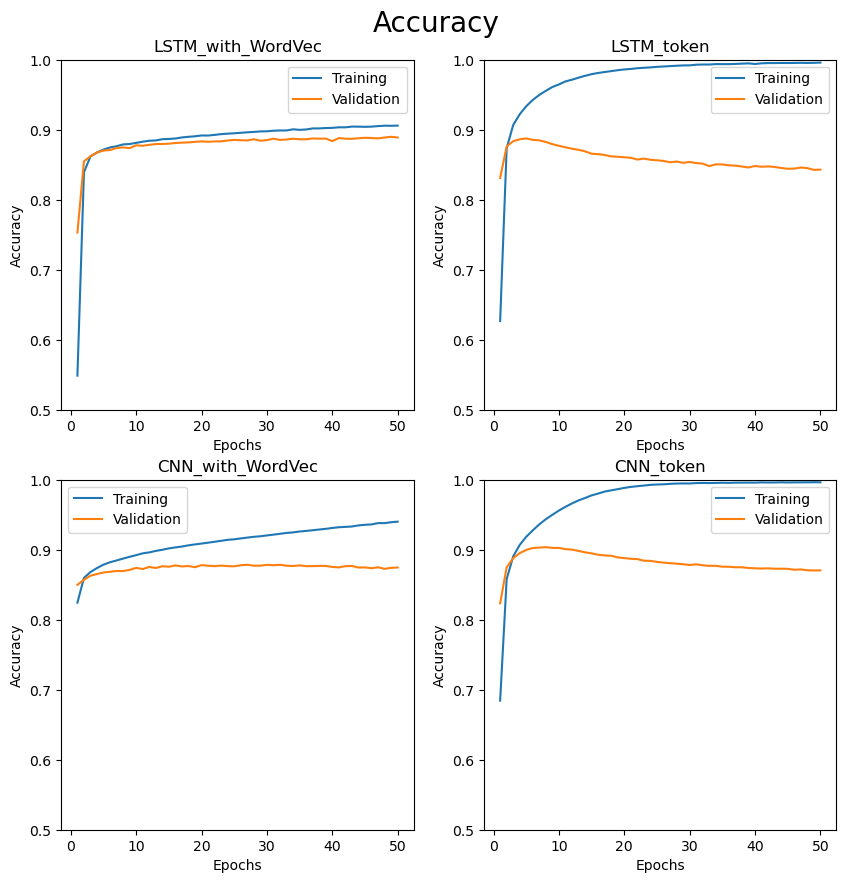

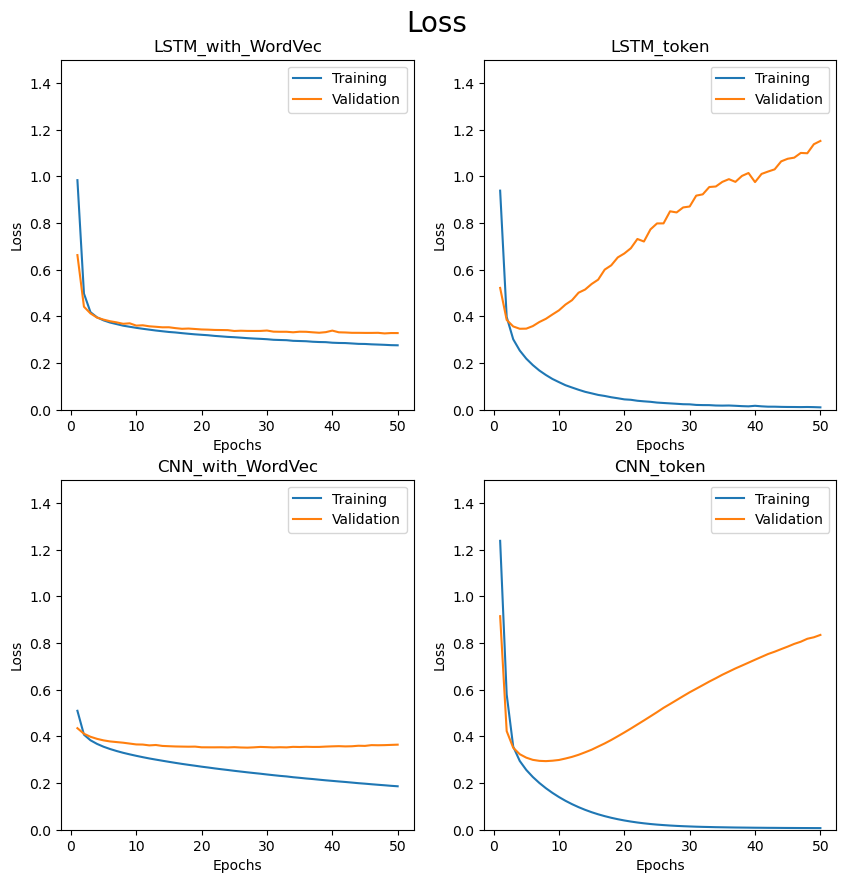

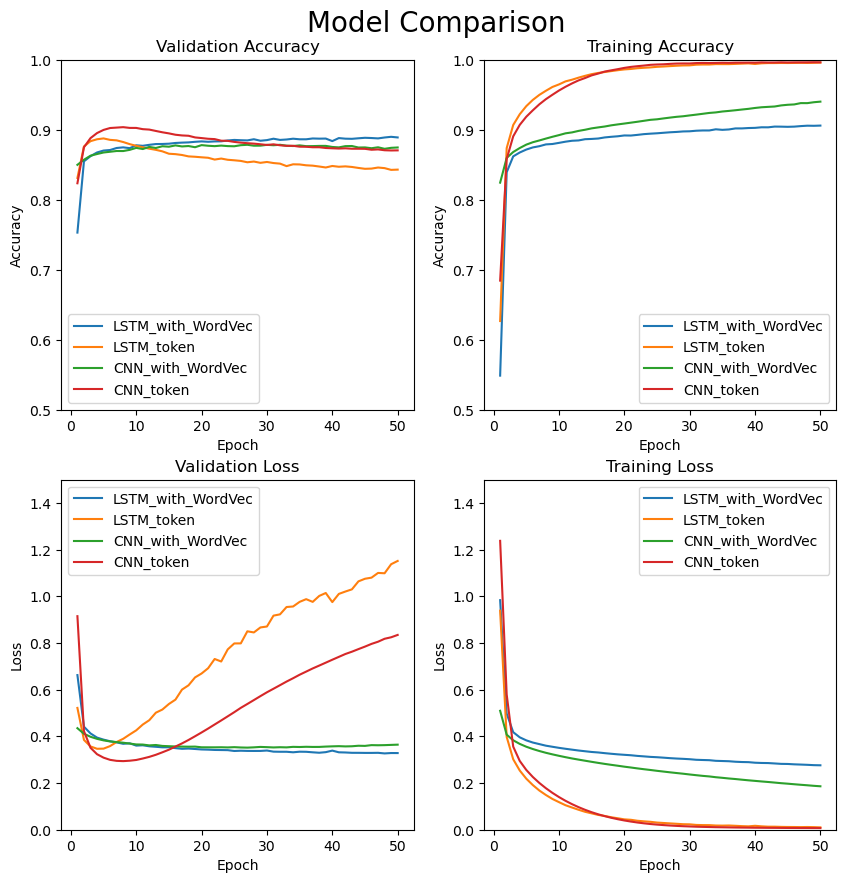

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,LSTM_with_WordVec,0.906,0.276,0.890,0.327,47
1,LSTM_token,0.996,0.010,0.888,0.347,3
2,CNN_with_WordVec,0.940,0.186,0.878,0.352,26
3,CNN_token,0.996,0.007,0.904,0.294,7


In [22]:
plot_all_plots(initial_stats, plot_type = 'accuracy', cols = 2)
plot_all_plots(initial_stats, plot_type = 'loss', cols = 2)
plot_models_together(initial_stats)
create_summary_table(initial_stats)

# Hyperparemeter Tuning
After looking at the models, I decided to do some hyperparameter tuning on both the LSTM and CNN WordVec models. I chose the WordVec models to tune, since they didn’t have the same propensity to rapidly overfit, compared to the more traditional text vectorization. I chose to use both the LSTM and CNN models because in the initial tests there wasn’t a huge difference, and I wanted to see if I could determine if one was better than the other.
## LSTM Tuning
For the LSTM tuning, I decided to try changing the number of units of the dense layers in the model to see if increasing them would have an effect on the overall accuracy of the model. I also tried adjusting the number of units of the LSTM layer to see if that would change anything.
### Dense Layer 128


In [74]:
lstm_wordvec_model_hp1 = Model_Seq([vectorize_layer,
          layers.Embedding(nb_words,
                   embed_size,
                   weights=[embedding_matrix],
                   trainable=False),
          layers.LSTM(64),
        layers.Dense(128, activation='relu'),
        layers.Dense(4,  activation='softmax')
         ], name = 'LSTM_WordVec_Dense_128', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.0001)

In [75]:
lstm_wordvec_model_hp1.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 10s 10ms/step - loss: 0.7200 - accuracy: 0.7166 - val_loss: 0.4572 - val_accuracy: 0.8516
Epoch 2/50
704/704 [==============================] - 6s 9ms/step - loss: 0.4184 - accuracy: 0.8616 - val_loss: 0.4047 - val_accuracy: 0.8652
Epoch 3/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3840 - accuracy: 0.8705 - val_loss: 0.3843 - val_accuracy: 0.8708
Epoch 4/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3677 - accuracy: 0.8759 - val_loss: 0.3787 - val_accuracy: 0.8716
Epoch 5/50
704/704 [==============================] - 7s 10ms/step - loss: 0.3560 - accuracy: 0.8791 - val_loss: 0.3640 - val_accuracy: 0.8775
Epoch 6/50
704/704 [==============================] - 7s 10ms/step - loss: 0.3476 - accuracy: 0.8822 - val_loss: 0.3559 - val_accuracy: 0.8792
Epoch 7/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3409 - accuracy: 0.8840 - val_loss: 0.3549 - val_accuracy: 0.8807
Ep

### Dense Layer 512

In [76]:
lstm_wordvec_model_hp2 = Model_Seq([vectorize_layer,
          layers.Embedding(nb_words,
                   embed_size,
                   weights=[embedding_matrix],
                   trainable=False),
          layers.LSTM(64),
        layers.Dense(512, activation='relu'),
        layers.Dense(4,  activation='softmax')
         ], name = 'LSTM_WordVec_Dense_512', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.0001)

In [77]:
lstm_wordvec_model_hp2.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 9s 10ms/step - loss: 0.7273 - accuracy: 0.6756 - val_loss: 0.4733 - val_accuracy: 0.8427
Epoch 2/50
704/704 [==============================] - 7s 10ms/step - loss: 0.4175 - accuracy: 0.8614 - val_loss: 0.4061 - val_accuracy: 0.8656
Epoch 3/50
704/704 [==============================] - 7s 9ms/step - loss: 0.3791 - accuracy: 0.8737 - val_loss: 0.3812 - val_accuracy: 0.8714
Epoch 4/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3632 - accuracy: 0.8788 - val_loss: 0.3737 - val_accuracy: 0.8741
Epoch 5/50
704/704 [==============================] - 7s 10ms/step - loss: 0.3512 - accuracy: 0.8825 - val_loss: 0.3618 - val_accuracy: 0.8778
Epoch 6/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3416 - accuracy: 0.8848 - val_loss: 0.3505 - val_accuracy: 0.8806
Epoch 7/50
704/704 [==============================] - 7s 10ms/step - loss: 0.3356 - accuracy: 0.8859 - val_loss: 0.3495 - val_accuracy: 0.8816
Ep

### LSTM Units 256

In [78]:
lstm_wordvec_model_hp3 = Model_Seq([vectorize_layer,
          layers.Embedding(nb_words,
                   embed_size,
                   weights=[embedding_matrix],
                   trainable=False),
          layers.LSTM(256),
        layers.Dense(128, activation='relu'),
        layers.Dense(4,  activation='softmax')
         ], name = 'LSTM_WordVec_LSTM_256', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.0001)

In [79]:
lstm_wordvec_model_hp3.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 14s 16ms/step - loss: 0.5041 - accuracy: 0.8197 - val_loss: 0.3860 - val_accuracy: 0.8685
Epoch 2/50
704/704 [==============================] - 11s 15ms/step - loss: 0.3703 - accuracy: 0.8740 - val_loss: 0.3704 - val_accuracy: 0.8717
Epoch 3/50
704/704 [==============================] - 10s 14ms/step - loss: 0.3536 - accuracy: 0.8790 - val_loss: 0.3662 - val_accuracy: 0.8729
Epoch 4/50
704/704 [==============================] - 10s 14ms/step - loss: 0.3417 - accuracy: 0.8821 - val_loss: 0.3510 - val_accuracy: 0.8792
Epoch 5/50
704/704 [==============================] - 11s 15ms/step - loss: 0.3333 - accuracy: 0.8832 - val_loss: 0.3405 - val_accuracy: 0.8823
Epoch 6/50
704/704 [==============================] - 11s 15ms/step - loss: 0.3234 - accuracy: 0.8876 - val_loss: 0.3334 - val_accuracy: 0.8845
Epoch 7/50
704/704 [==============================] - 11s 16ms/step - loss: 0.3186 - accuracy: 0.8891 - val_loss: 0.3426 - val_accuracy:

## CNN
For the CNN model, I adjusted how many filters were used in the convolution layer, to see if more filters would have a positive impact on the model.
### Filters 256

In [81]:
cnn_model_word_vec_hp1 = Model_Seq([vectorize_layer,
                                    layers.Embedding(nb_words,
                                        embed_size,
                                        weights=[embedding_matrix],
                                        trainable=False),
                                     layers.Conv1D(256, 3, activation = 'relu', padding = 'valid'),
                                     layers.GlobalMaxPooling1D(),
                                     layers.Dense(4, activation='softmax')], name = 'CNN_WordVec_filter_256', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.00001)

cnn_model_word_vec_hp1.summary()

Model: "CNN_WordVec_filter_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, None, 256)         13967360  
                                                                 
 conv1d_3 (Conv1D)           (None, None, 256)         196864    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_13 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 14,165,252
Trainable params: 1

In [82]:
cnn_model_word_vec_hp1.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 6s 8ms/step - loss: 0.8038 - accuracy: 0.7136 - val_loss: 0.5434 - val_accuracy: 0.8204
Epoch 2/50
704/704 [==============================] - 5s 7ms/step - loss: 0.4986 - accuracy: 0.8323 - val_loss: 0.4796 - val_accuracy: 0.8381
Epoch 3/50
704/704 [==============================] - 5s 7ms/step - loss: 0.4586 - accuracy: 0.8438 - val_loss: 0.4566 - val_accuracy: 0.8441
Epoch 4/50
704/704 [==============================] - 5s 7ms/step - loss: 0.4392 - accuracy: 0.8503 - val_loss: 0.4433 - val_accuracy: 0.8478
Epoch 5/50
704/704 [==============================] - 5s 7ms/step - loss: 0.4260 - accuracy: 0.8547 - val_loss: 0.4340 - val_accuracy: 0.8508
Epoch 6/50
704/704 [==============================] - 5s 7ms/step - loss: 0.4157 - accuracy: 0.8579 - val_loss: 0.4267 - val_accuracy: 0.8530
Epoch 7/50
704/704 [==============================] - 5s 7ms/step - loss: 0.4074 - accuracy: 0.8605 - val_loss: 0.4205 - val_accuracy: 0.8546
Epoch 

### Filters 512

In [85]:
cnn_model_word_vec_hp2 = Model_Seq([vectorize_layer,
                                    layers.Embedding(nb_words,
                                        embed_size,
                                        weights=[embedding_matrix],
                                        trainable=False),
                                     layers.Conv1D(512, 3, activation = 'relu', padding = 'valid'),
                                     layers.GlobalMaxPooling1D(),
                                     layers.Dense(4, activation='softmax')], name = 'CNN_WordVec_filter_512', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.00001)

In [86]:
cnn_model_word_vec_hp2.train_model(50, batch_size = 128)

Epoch 1/50
704/704 [==============================] - 13s 16ms/step - loss: 0.6839 - accuracy: 0.7671 - val_loss: 0.4984 - val_accuracy: 0.8343
Epoch 2/50
704/704 [==============================] - 6s 9ms/step - loss: 0.4649 - accuracy: 0.8435 - val_loss: 0.4551 - val_accuracy: 0.8438
Epoch 3/50
704/704 [==============================] - 6s 9ms/step - loss: 0.4341 - accuracy: 0.8532 - val_loss: 0.4368 - val_accuracy: 0.8495
Epoch 4/50
704/704 [==============================] - 6s 8ms/step - loss: 0.4168 - accuracy: 0.8579 - val_loss: 0.4251 - val_accuracy: 0.8526
Epoch 5/50
704/704 [==============================] - 6s 8ms/step - loss: 0.4044 - accuracy: 0.8618 - val_loss: 0.4171 - val_accuracy: 0.8558
Epoch 6/50
704/704 [==============================] - 6s 9ms/step - loss: 0.3946 - accuracy: 0.8650 - val_loss: 0.4105 - val_accuracy: 0.8584
Epoch 7/50
704/704 [==============================] - 6s 8ms/step - loss: 0.3865 - accuracy: 0.8678 - val_loss: 0.4047 - val_accuracy: 0.8606
Epoc

In [12]:
# Save the stats to disk incase the session ends
json_out(lstm_wordvec_model_hp1.stats| lstm_wordvec_model_hp2.stats |lstm_wordvec_model_hp3.stats | cnn_model_word_vec_hp1.stats | cnn_model_word_vec_hp2.stats, 'hp_all' )
hyperparameter_stats = json_to_dict('hp_all.json')

## Hyperparameter Results
Upon initial glance, there does not appear to be a great change with the adjustment of any of the hyperparmeters. The CNN models did worse than the LSTM models, and increasing the layers in the CNN model appeared to make the model perform slightly worse. 

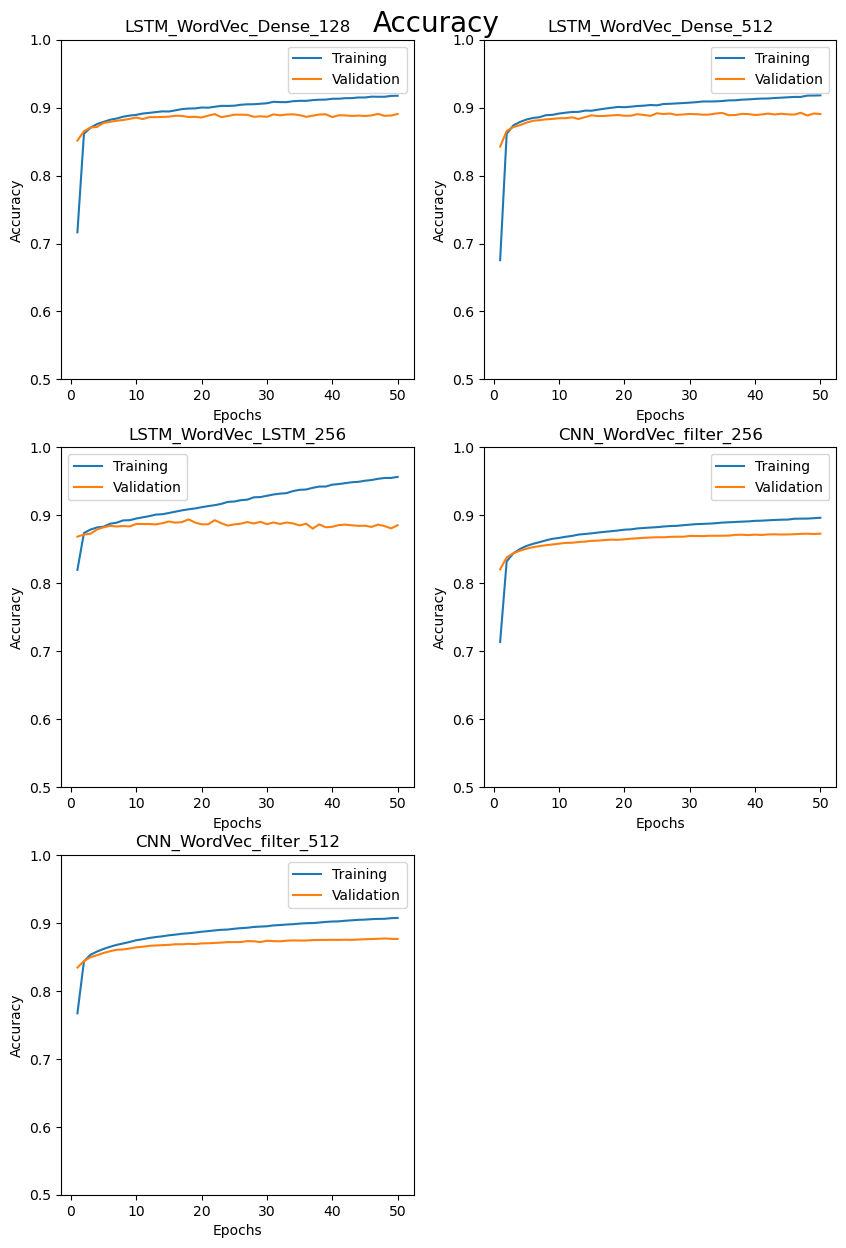

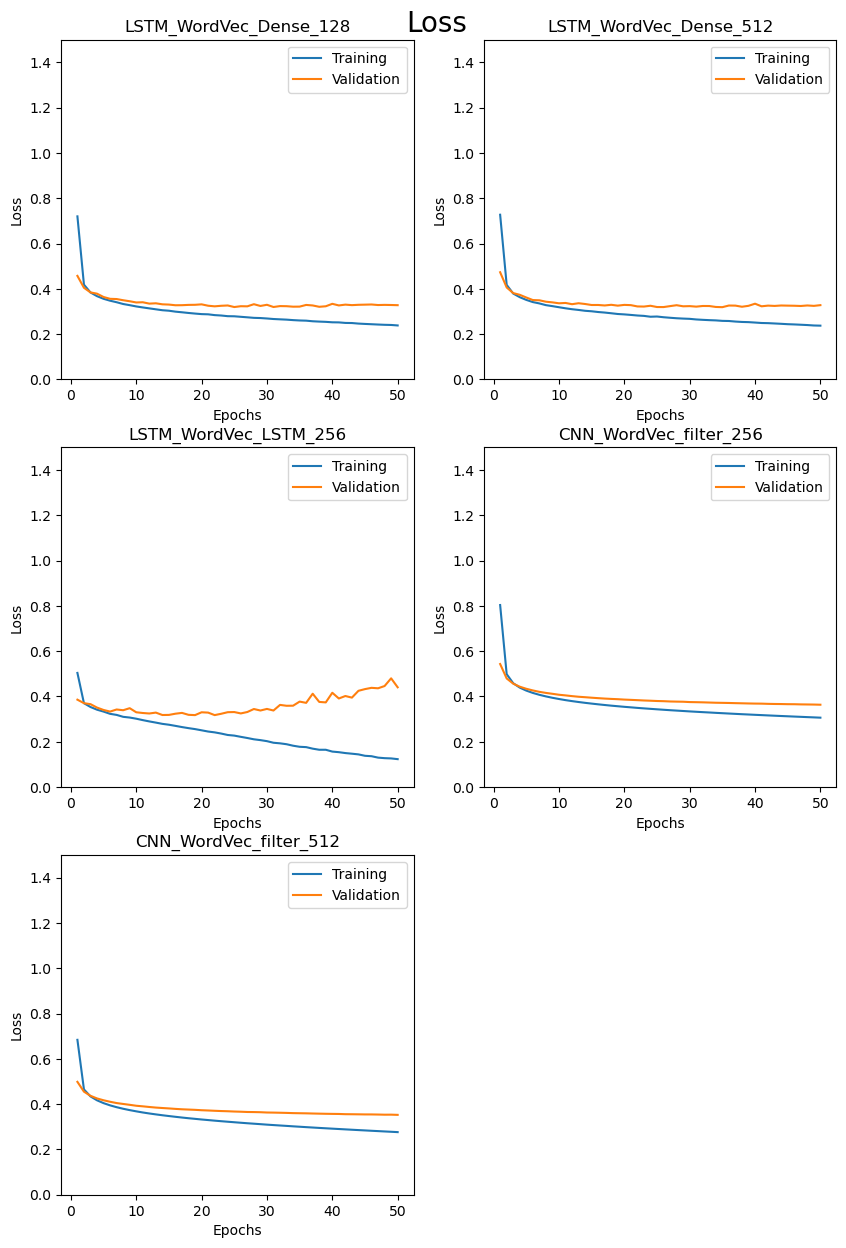

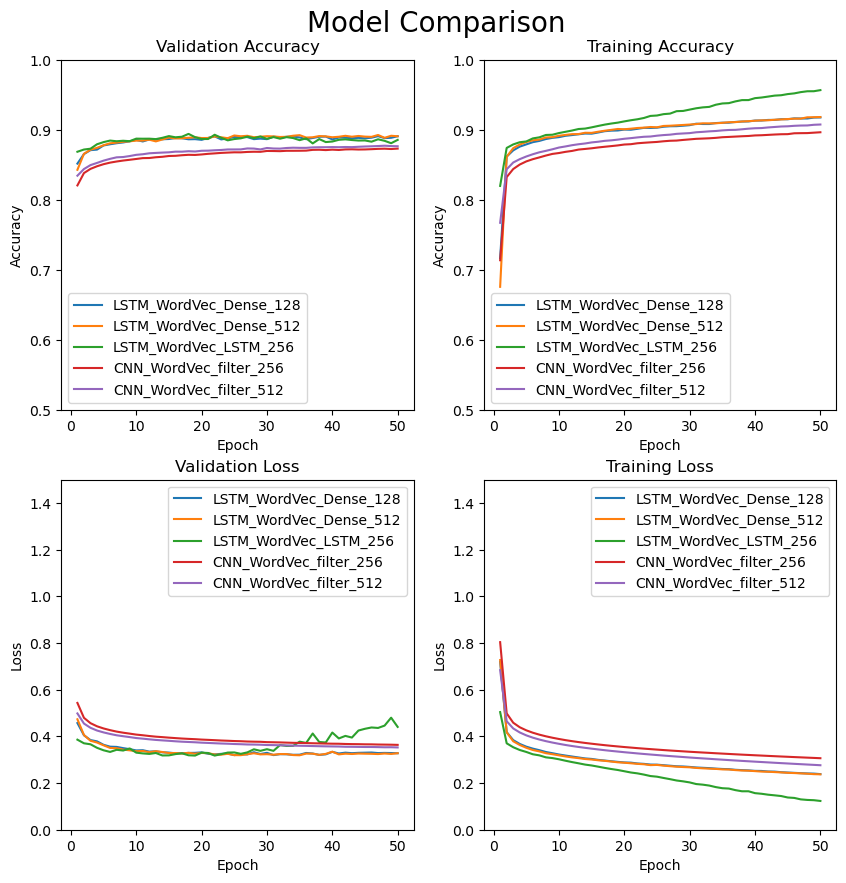

In [14]:
plot_all_plots(hyperparameter_stats, plot_type = 'accuracy', cols = 2)
plot_all_plots(hyperparameter_stats, plot_type = 'loss', cols = 2)
plot_models_together(hyperparameter_stats)

## Final Hyperparameter Comparisons
Comparing the hyperparameter adjustments to the previous models does show very little change after the hyperparameter adjustments. In fact, the the CNN models did worse with increased filters. One way in which the model might be tuned further would be to try and reducing filter size of the CNN models, and see if there is any improvement. 

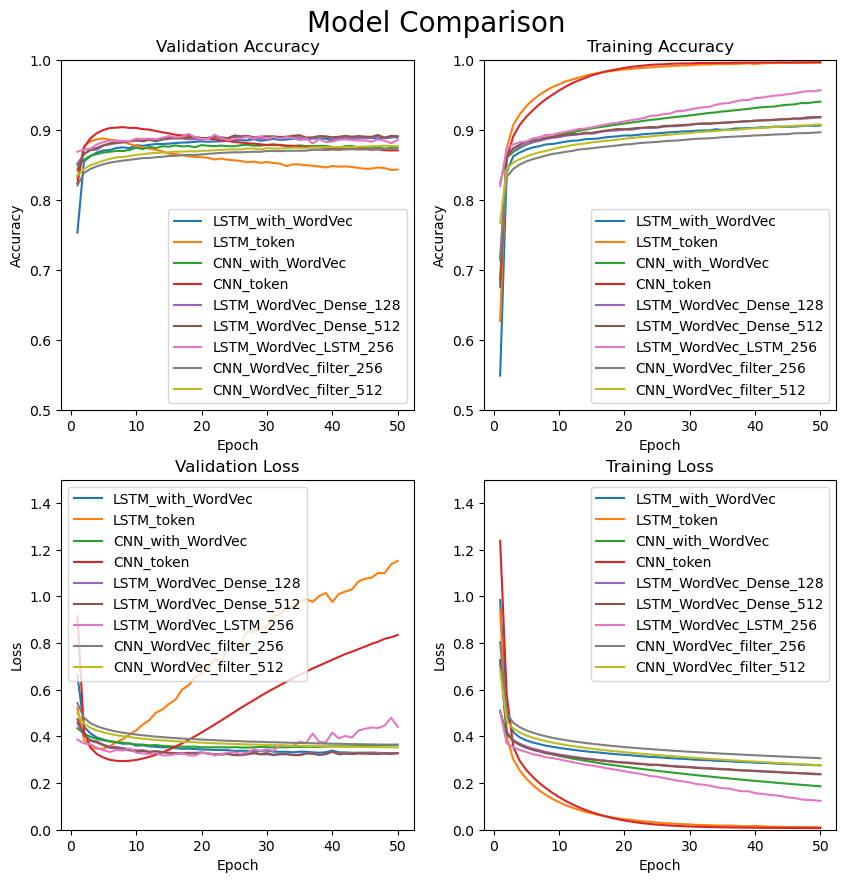

,Model,Max Acc,Minnimum Loss,Max Val Acc,Min Val Loss,Epoch of Min Val Loss
0,LSTM_with_WordVec,0.906,0.276,0.890,0.327,47
1,LSTM_token,0.996,0.010,0.888,0.347,3
2,CNN_with_WordVec,0.940,0.186,0.878,0.352,26
3,CNN_token,0.996,0.007,0.904,0.294,7
4,LSTM_WordVec_Dense_128,0.918,0.238,0.891,0.320,24
5,LSTM_WordVec_Dense_512,0.918,0.237,0.892,0.319,34
6,LSTM_WordVec_LSTM_256,0.957,0.123,0.894,0.318,18
7,CNN_WordVec_filter_256,0.896,0.306,0.873,0.364,49
8,CNN_WordVec_filter_512,0.907,0.276,0.877,0.353,49


In [33]:
plot_models_together(initial_stats | hyperparameter_stats)
create_summary_table(initial_stats| hyperparameter_stats)

# Final Model
## Architecture
After looking at all of the data, I ultimately decided to use the CNN model without the WordVec model. All of the models were really close, but tuning hyperparameters didn't seem to help the WordVec model much, and this model still beat those models slightly, which makes me think that is has the most potential. It also had the potential to train with less runtime, since it needed significantly less epochs to get to its maximum validation accuracy.

In [53]:
final_model = Model_Seq([vectorize_layer,
       layers.Embedding(
        input_dim=word_count,
        output_dim=256,
        mask_zero=True),
     layers.Conv1D(256, 3, activation = 'relu', padding = 'valid'),
     layers.GlobalMaxPooling1D(),
     layers.Dense(4, activation='softmax')], name = 'Final_Model', X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, inital_lr=.0001)


In [55]:
final_model.train_model(4, batch_size = 128)

Epoch 1/4
704/704 [==============================] - 269s 382ms/step - loss: 0.8910 - accuracy: 0.7792 - val_loss: 0.4157 - val_accuracy: 0.8751
Epoch 2/4
704/704 [==============================] - 242s 343ms/step - loss: 0.3357 - accuracy: 0.8944 - val_loss: 0.3245 - val_accuracy: 0.8960
Epoch 3/4
704/704 [==============================] - 239s 340ms/step - loss: 0.2546 - accuracy: 0.9188 - val_loss: 0.3006 - val_accuracy: 0.9029
Epoch 4/4
704/704 [==============================] - 239s 340ms/step - loss: 0.2047 - accuracy: 0.9350 - val_loss: 0.2936 - val_accuracy: 0.9053


In [58]:
#json_out(final_model.stats, 'final_model')
final_stats = json_to_dict('final_model.json')

### Summary
After the model completed running, I verified that there was no evidence of overfitting, which would be seen with an increase of the validation loss, or a decrease of the validation accuracy.

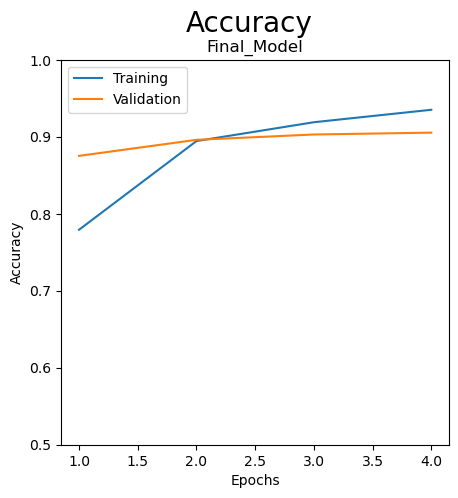

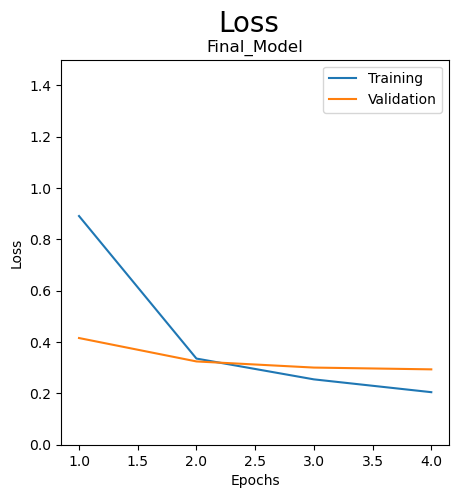

In [59]:
plot_all_plots(final_stats, plot_type = 'accuracy', cols = 1)
plot_all_plots(final_stats, plot_type = 'loss', cols = 1)

## Test Data
### Model
One important step with any model is to check it against unseen data to see how accurate it is. For this purpose, I used the test data from the dataset. I ran this data through the model and made a prediction about class labels. 


In [81]:
pred_test = predict_from_model(final_model, X_test)

238/238 [==============================] - 4s 18ms/step


In [82]:
test_acc = accuracy_score(y_test, pred_test)
test_metrics = precision_recall_fscore_support(y_test, pred_test)

In [83]:
test_metrics_df = pd.DataFrame(test_metrics, index = ['Precision', 'Recall', 'F-beta', 'Support'], columns = class_ids).T
test_metrics_df['Support'] =test_metrics_df['Support'].astype(int)

### Results
Overall, the model did fairly well. Looking at the metrics and a confusion chart, it struggles the most differentiating between 'Business' and 'Sci/tech.' 'Business' had the worst metrics across the board, with the model often assuming 'Business' was other categories, especially the aforementioned 'Sci/Tech.'

The models did the best with 'Sports' with high recall and precision values. The place that it tended to struggle with 'Sports' is telling it apart from 'World'. It also had more of a tendency to produce false positives for 'Sports', compared to false negatives for 'Sports.' To me, it makes sense that it did the best with 'Sports,' since there are a lot of specific words, that are applied to sports. However, many sports terms are used as metaphors in other contexts, so it isn't surprising that this doesn't result in perfect results.

It had a final accuracy of .90, which is not that far off the training accuracy of the final model. This is a good place to be since, it shows that we probably didn't overfit the training data.


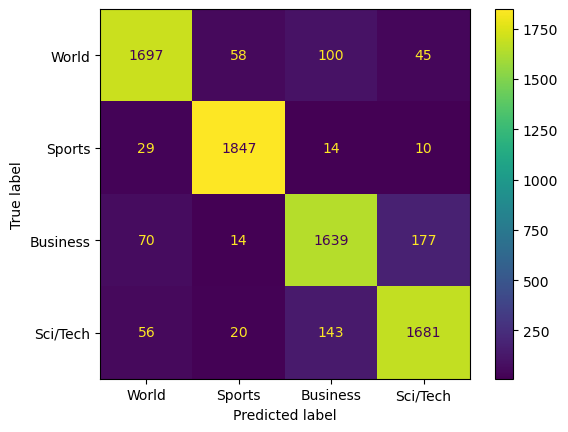

,Precision,Recall,F-beta,Support
World,0.916,0.893,0.905,1900
Sports,0.953,0.972,0.962,1900
Business,0.864,0.863,0.864,1900
Sci/Tech,0.879,0.885,0.882,1900


Overall Accuracy: 0.903


In [85]:
cm = confusion_matrix(y_test, pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels = class_ids).plot()
plt.title = 'Test'
plt.show()
display(test_metrics_df.round(3))
print(f"Overall Accuracy: {test_acc:.3f}")

## Improvements Discussion
While the final model was in no way awful, there are lots of ways this model could be improved. I was surprised that both types of models ended with very similar accuracy and trying to change hyperparameters had very little effect on the overall outcome. Certainly, there are more hyperparameters that could be tuned in both the CNN and LTSM Models, to see if accuracy could be improved, or the speed of computation could be improved. However, there is no obvious hyperparameter that could be changed to improve the model.

There are many different text vectorization techniques that could be used with this model. I chose to naively vectorize the text, and I also used a WordVec model that I trained off the data. In the end, the best model did not use the WordVec model for its training. There are WordVec models that are pretrained that could possibly allow the creation of a more accurate matrix for the embedding layer.

Data augmentation is another way in which the model could be improved. This could be done by duplicating the news articles, but replacing all of the words with synonyms. This would have the effect of increasing the vocabulary of the model, so that future, unseen data, might be able to be categorized better. 

## Final Conclusion
The model had an overall accuracy of 90 percent on the test data, which is okay, but certainly not perfect. It struggled more with some categories than others, especially between 'Business' and 'Sci/Tech,' but still did an okay job on those. That brings up the question is the model "good enough?" That would depend on the application of the model. There are probably few to no life or death situations where a miscategorized news article could results in death or harm, so there is a good chance it is good enough. But at the same time, if you are using this in a new aggregator, customers probably aren't going to /be thrilled with a product that only categorizes 9 out of every ten articles correctly. In reality, the answer to the question "Is the model good enough?" is "it depends..."


# References
Anand, Aman. "AG News Classification Dataset." *Kaggle.* https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

Binhuraib, Taha. "NLP with CNNs." * Towrds Data Science.* October 13, 2020. https://towardsdatascience.com/nlp-with-cnns-a6aa743bdc1e*

Ganegedara, Thushan. "Intuitive Guide to Understanding GloVe Embeddings." *Towards Data Science.* May 5th, 2019. https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010

"Generating WordClouds in Python Tutorial." *DataCamp.* February 2023. https://www.datacamp.com/tutorial/wordcloud-python

Gulli, Antonio. "AG's corpus of news articles." http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html

Řehůřek, Radim. "Word2Vec Model". *Gensim.* December 21, 2022. https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

Saturn Cloud. "Using Pretrained Gensim Word2Vec Embeddings in Keras: A Comprehensive Guide." *Saturn Cloud Blog.* July 10th, 2023. https://saturncloud.io/blog/using-pretrained-gensim-word2vec-embeddings-in-keras-a-comprehensive-guide/

Zhang, Xiang and Zhao, Junbo and LeCun, Yann. "Character-level Convolutional Networks for Text Classification." *Arxiv.* 2016. https://arxiv.org/abs/1509.01626v3